# Deep Neural Network for Image Classification: Application I

- Build and apply a deep neural network to supervised learning.
- 2 Layer NN

# 1 - Packages & Load Data

- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [14]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

from tools.activation_function import sigmoid, sigmoid_derivative, ReLU, ReLU_derivative, tanh, tanh_derivative

%matplotlib inline
np.random.seed(1)

In [15]:
# Loading the data
def load_dataset():  
    train_dataset = h5py.File('data/train_catvnoncat.h5', "r")
    # 209 samples, 64 * 64 pixels
    train_X = np.array(train_dataset["train_set_x"][:]) # (209, 64, 64, 3) 
    train_y = np.array(train_dataset["train_set_y"][:]) # (209,)
  
    test_dataset = h5py.File('data/test_catvnoncat.h5', "r")  
    # 50 samples
    test_X = np.array(test_dataset["test_set_x"][:]) # (50, 64, 64, 3)
    test_y = np.array(test_dataset["test_set_y"][:]) # (50,)
  
    # label
    classes = np.array(test_dataset["list_classes"][:]) # [b'non-cat' b'cat'] 
    
    # y = [...] => y = [[...]]
    train_y = np.array([train_y]) # train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = np.array([test_y]) # test_y = test_y.reshape((1, test_y.shape[0])) 
    
    return train_X, train_y, test_X, test_y, classes

train_X, train_y, test_X, test_y, classes = load_dataset()

y = 0. It's a non-cat picture.


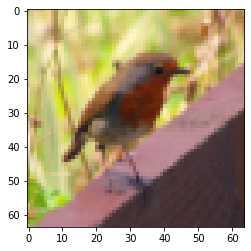

In [16]:
# show Image
def showImg ():
    index = 10
    plt.imshow(train_X[index])
    print ("y = " + str(train_y[0, index]) + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")

showImg()

In [17]:
# Explore ur dataset

# print(train_X.shape) # (209, 64, 64, 3)
# print(train_y.shape) # (1, 209)

# the number of training samples
m_train = train_y.shape[1] # 209

# the number of test samples
m_test = test_y.shape[1] # 50

# size of image 64 * 64 * 3
num_px = train_X.shape[1: 4] # (64, 64, 3)


In [18]:
def handle_data ():
    # train_X: (209, 64, 64, 3) => (209, 64 * 64 * 3) => (64 * 64 * 3, 209)
    X_train_flatten = train_X.reshape(m_train, -1).T
    X_test_flatten = test_X.reshape(m_test, -1).T
    
    # Standardize data to have feature values between 0 and 1.
    X_train_flatten = X_train_flatten / 255
    X_test_flatten = X_test_flatten / 255

    return X_train_flatten, X_test_flatten

X_train_flatten, X_test_flatten = handle_data()
# print(X_train_flatten.shape) # (12288, 209)
# print(X_test_flatten.shape) # (12288, 50)

# 2 - Model (Deep NN)

## 2-1 L-layer deep neural network
![L-layer deep neural network](https://github.com/Kulbear/deep-learning-coursera/raw/997fdb2e2db67acd45d29ae418212463a54be06d/Neural%20Networks%20and%20Deep%20Learning/images/LlayerNN_kiank.png)

# 2-2 Process

1. initialize parameters / define hyperparameters

2. train: 
```
   a. forward propagation
   b. J = cost function
   c. backward propagation
   d. gradient descent
```

3. predict

# 3 - Two - Layer NN

![image](https://github.com/Kulbear/deep-learning-coursera/raw/997fdb2e2db67acd45d29ae418212463a54be06d/Neural%20Networks%20and%20Deep%20Learning/images/2layerNN_kiank.png)

In [62]:
class TwoLayerNN ():
    def __init__(self, Layers, X, y):
        # 输入层, 隐藏层, 输出层的个数
        self.input_n = Layers[0]
        self.hidden_n = Layers[1]
        self.output_n = Layers[2]
        
        # Weights and Bias
        W1 = np.random.randn(self.input_n, self.hidden_n) * 0.01
        b1 = np.zeros(shape = (self.hidden_n, 1))
        
        W2 = np.random.randn(self.hidden_n, self.output_n) * 0.01
        b2 = np.zeros(shape = (self.output_n, 1))
        
        self.parameters = {
            'W1': W1,
            'b1': b1,
            'W2': W2,
            'b2': b2
        }
        
        # hyperparameters
        self.hyperparameters = {
            'iterations': 3000,
            'alpha': 0.0075
        }
        
        self.A = {
            'A0': X
        }
        
        self.y = y
        self.J = 0
        self.dJ_dW_db = {}
    
    def forward_item (self, A_prev, W, b):
        return np.dot(W.T, A_prev) + b

    def forward_propagation (self):
        A = self.A
        parameters = self.parameters

        A0 = A['A0'] # (12288, 209)
        
        # Z1, A1 (7 * 209)
        # Z1 = np.dot(parameters['W1'].T, A0) + parameters['b1']
        Z1 = self.forward_item(A0, parameters['W1'], parameters['b1'])
        A1 = ReLU(Z1)
        
        # Z2, A2 (1 * 209)
        # Z2 = np.dot(parameters['W2'].T, A1) + parameters['b2']
        Z2 = self.forward_item(A1, parameters['W2'], parameters['b2'])
        A2 = sigmoid(Z2)
        
        # 更新self.A (除了A0外)
        self.A['A1'] = A1
        self.A['A2'] = A2
        
    def cost_function (self):
        y, A2 = self.y, self.A['A2']
        loss = -y * np.log(A2) - (1 - y) * np.log(1 - A2) # (1, 209)
        m = loss.shape[1]
        self.J = (1 / m) * np.sum(loss) 
        
    def get_dJ_dZ (self, key, dJ_dZ_next, A, W_next):
        if key == 'relu':
            dJ_dA = np.dot(W_next, dJ_dZ_next)
            dA_dZ = ReLU_derivative(A)
            dJ_dZ = dJ_dA * dA_dZ
            return dJ_dZ
        
    def backward_item (self, dJ_dZ, A_prev, m):
        dJ_dW = (1 / m) * np.dot(A_prev, dJ_dZ.T)
        dJ_db = (1 / m) * np.sum(dJ_dZ, axis = 1, keepdims = True)
        return dJ_dW, dJ_db
        
    def backward_propagation (self):
        J = self.J
        y = self.y
        parameters = self.parameters
        A = self.A
        
        m = A['A1'].shape[1] # 209

        """
        # dJ_dA2 = -y / A2 + (1 - y) / (1 - A2) # (1, 209)
        # dA2_dZ2 = sigmoid_derivative(A2) # (1, 209)
        # dJ_dZ2 = dJ_dA2 * dA2_dZ2
        OR
        # dJ_dZ2 = A2 - y 
        """
        # ===== Layer2 =====
        dJ_dZ2 = A['A2'] - y # (1, 209)
        """
        # dJ_dW2 = (1 / m) * np.dot(A['A1'], dJ_dZ2.T) # (7, 209) * (1, 209).T = (7, 1)
        # dJ_db2 = (1 / m) * np.sum(dJ_dZ2, axis = 1, keepdims = True) # (1, 1)
        """
        dJ_2 = self.backward_item(dJ_dZ2, A['A1'], m)

        self.dJ_dW_db['dJ_dZ2'] = dJ_dZ2
        self.dJ_dW_db['dJ_dW2'] = dJ_2[0]
        self.dJ_dW_db['dJ_db2'] = dJ_2[1]
        
        
        # ===== Layer1 =====
        """
        # dJ_dA1 = np.dot(parameters['W2'], dJ_dZ2) # (7, 209)
        # dA1_dZ1 = ReLU_derivative(A['A1']) # (7, 209)
        # dJ_dZ1 = dJ_dA1 * dA1_dZ1 # (7, 209)
        """
        dJ_dZ1 = self.get_dJ_dZ ('relu', dJ_dZ2, A['A1'], parameters['W2'])
        """
        # dJ_dW1 = (1 / m) * np.dot(A['A0'], dJ_dZ1.T) # (12288, 7)
        # dJ_db1 = (1 / m) * np.sum(dJ_dZ1, axis = 1, keepdims = True) # (7, 1)
        """
        dJ_1 = self.backward_item(dJ_dZ1, A['A0'], m)
        self.dJ_dW_db['dJ_dZ1'] = dJ_dZ1
        self.dJ_dW_db['dJ_dW1'] = dJ_1[0]
        self.dJ_dW_db['dJ_db1'] = dJ_1[1]
        # print(self.dJ_dW_db)
        
    def train (self):
        alpha = self.hyperparameters['alpha']
        J_arr = []
        for i in range(self.hyperparameters['iterations']):
            self.forward_propagation()
            self.cost_function()
            if (i % 100 == 0):
                J_arr.append(self.J)

            self.backward_propagation()

            self.parameters['W2'] -= alpha * self.dJ_dW_db['dJ_dW2']
            self.parameters['b2'] -= alpha * self.dJ_dW_db['dJ_db2']
            
            self.parameters['W1'] -= alpha * self.dJ_dW_db['dJ_dW1']
            self.parameters['b1'] -= alpha * self.dJ_dW_db['dJ_db1']
            
        NN.cost_function()
        # print('A值: ', self.A)
        print('代价函数值: ', self.J)
        
        return J_arr
    
    def plot_J (self, J_arr):
        plt.plot(np.squeeze(J_arr))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(self.hyperparameters['alpha']))
        plt.show()
        
    def predict (self):
        self.forward_propagation()
        A2 = self.A['A2']
        predictions = np.round(A2)
        
        m = A2.shape[1]
        # print(predictions)
        accuracy = (1 - (1 / m) * np.sum(abs(predictions - self.y))) * 100
        print('训练精确度: ', accuracy)
        
    def CV (self, X_test, y_test):
        parameters = self.parameters
        Z1_test = self.forward_item(X_test, parameters['W1'], parameters['b1'])
        A1_test = ReLU(Z1_test)

        Z2_test = self.forward_item(A1_test, parameters['W2'], parameters['b2'])
        A2_test = sigmoid(Z2_test)
        
        y_test_predict = np.round(A2_test)
        m = A2_test.shape[1]
        accuracy = (1 - (1 / m) * np.sum(abs(y_test_predict - y_test))) * 100
        print('测试精确度: ', accuracy)
        
    def start (self):
        J_arr = self.train()
        self.plot_J(J_arr)


代价函数值:  0.020810850795617356


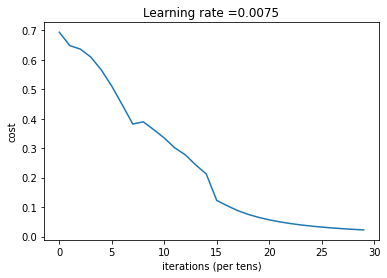

In [63]:
input_n = X_train_flatten.shape[0]
hidden_n = 7
output_n = 1
Layers = np.array([input_n, hidden_n, output_n])

# 运行
NN = TwoLayerNN(Layers, X_train_flatten, train_y)
NN.start()

In [64]:
NN.predict()
NN.CV(X_test_flatten, test_y)

训练精确度:  100.0
测试精确度:  68.0
